In [10]:
!pip install catboost

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

In [12]:
df = pd.read_csv('/content/drive/MyDrive/ML Datasets/ChatGPT/Smart_Task_Prioritizer_Improved.csv')
df.head()

,task_type,title,duration_minutes,urgency,deadline_urgency,importance_to_goals,depends_on_you,stress_level,motivation_level,enjoyment_level,task_blocking_others,priority
0,Work,Send report,44,1,Tomorrow,5,1,2,5,3,1,Low
1,Study,Revise notes,163,1,Tomorrow,5,0,4,5,2,0,Low
2,Study,Practice math,124,3,This Week,2,0,5,1,3,0,Low
3,Personal,Call mom,145,3,No Deadline,1,1,1,4,1,0,Low
4,Work,Send report,86,3,Tomorrow,5,1,1,4,2,0,Medium


In [13]:
df.shape

(5000, 12)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   task_type             5000 non-null   object
 1   title                 5000 non-null   object
 2   duration_minutes      5000 non-null   int64 
 3   urgency               5000 non-null   int64 
 4   deadline_urgency      5000 non-null   object
 5   importance_to_goals   5000 non-null   int64 
 6   depends_on_you        5000 non-null   int64 
 7   stress_level          5000 non-null   int64 
 8   motivation_level      5000 non-null   int64 
 9   enjoyment_level       5000 non-null   int64 
 10  task_blocking_others  5000 non-null   int64 
 11  priority              5000 non-null   object
dtypes: int64(8), object(4)
memory usage: 468.9+ KB


In [15]:
df.duplicated().sum()

np.int64(0)

In [16]:
df['priority'].value_counts()

,count
priority,
Low,2882
Medium,1992
High,126


In [17]:
df['deadline_urgency'].value_counts()

,count
deadline_urgency,
Today,865
Next Week,851
This Week,840
Overdue,829
No Deadline,809
Tomorrow,806


In [18]:
df.drop(columns=["title"], inplace=True)
df = pd.get_dummies(df, columns=['deadline_urgency'], prefix='deadline_urgency', drop_first=True, dtype=int)
df.head()

,task_type,duration_minutes,urgency,importance_to_goals,depends_on_you,stress_level,motivation_level,enjoyment_level,task_blocking_others,priority,deadline_urgency_No Deadline,deadline_urgency_Overdue,deadline_urgency_This Week,deadline_urgency_Today,deadline_urgency_Tomorrow
0,Work,44,1,5,1,2,5,3,1,Low,0,0,0,0,1
1,Study,163,1,5,0,4,5,2,0,Low,0,0,0,0,1
2,Study,124,3,2,0,5,1,3,0,Low,0,0,1,0,0
3,Personal,145,3,1,1,1,4,1,0,Low,1,0,0,0,0
4,Work,86,3,5,1,1,4,2,0,Medium,0,0,0,0,1


In [19]:
# Encoding categorical variables
encoder = LabelEncoder()
df["task_type"] = encoder.fit_transform(df["task_type"])
df.head()

,task_type,duration_minutes,urgency,importance_to_goals,depends_on_you,stress_level,motivation_level,enjoyment_level,task_blocking_others,priority,deadline_urgency_No Deadline,deadline_urgency_Overdue,deadline_urgency_This Week,deadline_urgency_Today,deadline_urgency_Tomorrow
0,4,44,1,5,1,2,5,3,1,Low,0,0,0,0,1
1,3,163,1,5,0,4,5,2,0,Low,0,0,0,0,1
2,3,124,3,2,0,5,1,3,0,Low,0,0,1,0,0
3,2,145,3,1,1,1,4,1,0,Low,1,0,0,0,0
4,4,86,3,5,1,1,4,2,0,Medium,0,0,0,0,1


<Axes: >

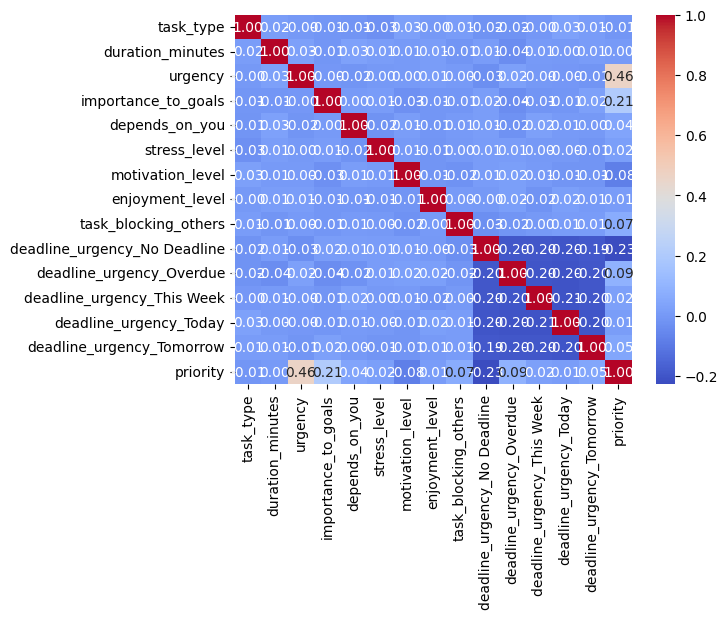

In [20]:
df_corr = df.drop(columns=["priority"])
df_corr['priority'] = encoder.fit_transform(df['priority'])
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")

In [22]:
X = df.drop(columns=["priority"])
y = df["priority"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), param_grid={
    'n_estimators': [40, 80, 100]}, cv=cv, scoring='balanced_accuracy', n_jobs=-1)
model.fit(X_train, y_train)
print("Best Params:", model.best_params_)
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Params: {'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

        High       0.93      0.56      0.70        25
         Low       0.97      0.99      0.98       571
      Medium       0.96      0.95      0.96       404

    accuracy                           0.97      1000
   macro avg       0.96      0.84      0.88      1000
weighted avg       0.97      0.97      0.96      1000



In [25]:
# --- RandomForest with Pipeline and RandomizedSearchCV ---
pipeline_rf = ImbPipeline([  # Use ImbPipeline
    ('scaler', StandardScaler()),
    ('resample', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

randomized_search_rf = RandomizedSearchCV(pipeline_rf, param_grid_rf, cv=StratifiedKFold(n_splits=5),
                                           n_iter=10, scoring='balanced_accuracy', random_state=42, n_jobs=-1)  # Reduce n_iter for faster testing
randomized_search_rf.fit(X_train, y_train)

print("Best RF Params:", randomized_search_rf.best_params_)
y_pred_rf = randomized_search_rf.predict(X_test)
print("RF Classification Report:\n", classification_report(y_test, y_pred_rf))

Best RF Params: {'rf__n_estimators': 50, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 10}
RF Classification Report:
               precision    recall  f1-score   support

        High       0.83      0.76      0.79        25
         Low       0.95      0.99      0.97       571
      Medium       0.97      0.92      0.94       404

    accuracy                           0.95      1000
   macro avg       0.92      0.89      0.90      1000
weighted avg       0.96      0.95      0.95      1000



In [26]:
# Define pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('catboost', CatBoostClassifier(verbose=0, random_state=42))
])

# Set parameter grid
param_grid = {
    'catboost__iterations': [100, 200],
    'catboost__depth': [4, 6, 8],
    'catboost__learning_rate': [0.03, 0.1]
}

# Stratified CV for balanced class splits
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='f1_macro',  # Use macro F1 to handle class imbalance
    cv=cv,
    n_jobs=-1
)

# Fit the model
grid.fit(X_train, y_train)

# Evaluate
y_pred = grid.predict(X_test)
print("Best Params:", grid.best_params_)
print(classification_report(y_test, y_pred))

Best Params: {'catboost__depth': 8, 'catboost__iterations': 200, 'catboost__learning_rate': 0.1}
              precision    recall  f1-score   support

        High       1.00      0.88      0.94        25
         Low       1.00      1.00      1.00       571
      Medium       0.99      1.00      0.99       404

    accuracy                           0.99      1000
   macro avg       0.99      0.96      0.97      1000
weighted avg       0.99      0.99      0.99      1000



In [27]:
# --- Gradient Boosting Example (XGBoost) ---
from xgboost import XGBClassifier

pipeline_xgb = ImbPipeline([
    ('scaler', StandardScaler()),
    ('resample', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)) #  No label encoder warning
])

param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 6, 9],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

randomized_search_xgb = RandomizedSearchCV(pipeline_xgb, param_grid_xgb, cv=StratifiedKFold(n_splits=5),
                                            n_iter=10, scoring='balanced_accuracy', random_state=42, n_jobs=-1)
y = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
randomized_search_xgb.fit(X_train, y_train)

print("\nBest XGB Params:", randomized_search_xgb.best_params_)
y_pred_xgb = randomized_search_xgb.predict(X_test)
print("XGB Classification Report:\n", classification_report(y_test, y_pred_xgb))


Best XGB Params: {'xgb__subsample': 1.0, 'xgb__n_estimators': 300, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 1.0}
XGB Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        25
           1       0.99      0.99      0.99       571
           2       0.98      0.98      0.98       404

    accuracy                           0.98      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.98      0.98      0.98      1000

